# Dependencies

In [1]:
import os, warnings, shutil, string, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tokenizers import ByteLevelBPETokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from tweet_utility_scripts import *
from tweet_utility_preprocess_scripts_word import *
import tweet_utility_preprocess_roberta_scripts_text as preprocess_text


SEED = 0
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)

# Tokenizer

In [2]:
MAX_LEN = 64
base_path = '/kaggle/input/qa-transformers/roberta/'
vocab_path = base_path + 'roberta-base-vocab.json'
merges_path = base_path + 'roberta-base-merges.txt'

tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

# Load data

In [3]:
punctuations = string.punctuation.replace('`', '')

def split_punctuation(text):
    for punctuation in punctuations:
        text = text.replace(f'{punctuation}', f' {punctuation} ')

    return re.sub(r'\s+', ' ', text).strip()

In [4]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')

# pre-process
train_df.dropna(inplace=True)
train_df = train_df.reset_index()
train_df.drop('index', axis=1, inplace=True)
train_df["text"] = train_df["text"].apply(lambda x: x.strip())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.strip())
train_df["text"] = train_df["text"].apply(lambda x: x.lower())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.lower())

# train_df["text"] = train_df["text"].apply(lambda x: split_punctuation(x))
# train_df["selected_text"] = train_df["selected_text"].apply(lambda x: split_punctuation(x))
train_df["selected_text"] = train_df.apply(lambda x: ' '.join([word for word in x['selected_text'].split() if word in x['text'].split()]), axis=1)

train_df['jaccard'] = train_df.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)
train_df['text_len'] = train_df['text'].apply(lambda x : len(x))
train_df['text_wordCnt'] = train_df['text'].apply(lambda x : len(x.split(' ')))
train_df['text_tokenCnt'] = train_df['text'].apply(lambda x : len(tokenizer.encode(x).ids))
train_df['selected_text_len'] = train_df['selected_text'].apply(lambda x : len(x))
train_df['selected_text_wordCnt'] = train_df['selected_text'].apply(lambda x : len(x.split(' ')))
train_df['selected_text_tokenCnt'] = train_df['selected_text'].apply(lambda x : len(tokenizer.encode(x).ids))

sentiment_cols = train_df['sentiment'].unique()

print('Train samples: %s' % len(train_df))
display(train_df.head())
display(train_df.describe())

Train samples: 27480


,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3
2,088c60f138,my boss is bullying me...,bullying,negative,0.200000,25,5,6,8,1,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3
4,358bd9e861,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,74,14,17,13,3,4


,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt
count,27480.000000,27480.000000,27480.000000,27480.000000,27480.000000,27480.000000,27480.000000
mean,0.591590,67.891958,13.341885,18.320451,35.985298,7.005968,9.471834
std,0.411113,35.638801,7.164694,9.780535,35.620323,6.915357,9.454710
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,0.142857,38.000000,7.000000,10.000000,8.000000,1.000000,2.000000
50%,0.692308,63.500000,12.000000,17.000000,22.000000,4.000000,6.000000
75%,1.000000,96.000000,19.000000,26.000000,54.000000,10.000000,14.000000
max,1.000000,141.000000,100.000000,100.000000,140.000000,33.000000,86.000000


## Remove noisy samples

In [5]:
print(f'Complete set nunmber of samples {len(train_df)}')

dirty_text_list = ['0b3fe0ca78', '4a265d8a34', 'ee20c2fdbe', '7f37ccff0a', 
                   'add398ab57', '90e8facdd7', 'c9ea30009c', '7d665a86e0', 
                   '99d16017ae', 'cd89b279ef', 'fefc0ed9f0', '5db6024b06', 
                   '2d059a6bc6']

dirty_selected_text_list = ['7da058a4f6', '13259c1890', '25810b3323', '6899e9aa17', 
                            'a99c5a9003', 'a21d9c38a8', '106e3d1042', '6ae7977873', 
                            '36c47981f9', '3686cff7dd', '4f57ed7ece', '8b31247f45', 
                            '5bada8d821', '9f19792407', '2225e0fa43']

train_df = train_df[~train_df['textID'].isin(dirty_text_list)]
train_df = train_df[~train_df['textID'].isin(dirty_selected_text_list)]

# Remove jaccard = 0
train_df = train_df[train_df['jaccard'] > 0]
train_df = train_df.reset_index()
train_df.drop('index', axis=1, inplace=True)

print(f'Cleaned set nunmber of samples {len(train_df)}')

Complete set nunmber of samples 27480
Cleaned set nunmber of samples 26882


# 5-Fold split

In [6]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['sentiment'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 21505, Validation size 5377
Fold: 2, Train size: 21505, Validation size 5377
Fold: 3, Train size: 21506, Validation size 5376
Fold: 4, Train size: 21506, Validation size 5376
Fold: 5, Train size: 21506, Validation size 5376


## Data imputation

In [7]:
train_df['imputed'] = False

##### Data imputation here #####

# # pre-process again
# train_df.dropna(inplace=True)
# train_df = train_df.reset_index()
# train_df.drop('index', axis=1, inplace=True)
# train_df["text"] = train_df["text"].apply(lambda x: x.strip())
# train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.strip())
# train_df["text"] = train_df["text"].apply(lambda x: x.lower())
# train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.lower())

# train_df['jaccard'] = train_df.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)
# train_df['text_len'] = train_df['text'].apply(lambda x : len(x))
# train_df['text_wordCnt'] = train_df['text'].apply(lambda x : len(x.split(' ')))
# train_df['text_tokenCnt'] = train_df['text'].apply(lambda x : len(tokenizer.encode(x).ids))
# train_df['selected_text_len'] = train_df['selected_text'].apply(lambda x : len(x))
# train_df['selected_text_wordCnt'] = train_df['selected_text'].apply(lambda x : len(x.split(' ')))
# train_df['selected_text_tokenCnt'] = train_df['selected_text'].apply(lambda x : len(tokenizer.encode(x).ids))

print(f"Original number of samples: {len(train_df[train_df['imputed'] == False])}")
print(f"Imputed number of samples: {len(train_df[train_df['imputed'] == True])}")

Original number of samples: 26882
Imputed number of samples: 0


## Tokenizer sanity check

In [8]:
for idx in range(10):
    print('\nRow %d' % idx)
    max_seq_len = 32
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    question = train_df['sentiment'].values[idx]
    
    _,  (target_start, target_end, _) = preprocess_roberta(' ' + text, selected_text, ' ' + question, tokenizer, max_seq_len)
    
    question_encoded = tokenizer.encode(question).ids
    question_size = len(question_encoded) + 3
    
    decoded_text = decode(target_start.argmax(), target_end.argmax(), text)
    
    print('text         : "%s"' % text)
    print('selected_text: "%s"' % selected_text)
    print('decoded_text : "%s"' % decoded_text)
    
    assert selected_text == decoded_text


Row 0
text         : "i`d have responded, if i were going"
selected_text: "i`d have responded, if i were going"
decoded_text : "i`d have responded, if i were going"

Row 1
text         : "sooo sad i will miss you here in san diego!!!"
selected_text: "sooo sad"
decoded_text : "sooo sad"

Row 2
text         : "my boss is bullying me..."
selected_text: "bullying"
decoded_text : "bullying"

Row 3
text         : "what interview! leave me alone"
selected_text: "leave me alone"
decoded_text : "leave me alone"

Row 4
text         : "sons of ****, why couldn`t they put them on the releases we already bought"
selected_text: "sons of ****,"
decoded_text : "sons of ****,"

Row 5
text         : "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth"
selected_text: "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth"
decoded_text : "http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on 

## Data generation sanity check

In [9]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 24
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    question = train_df['sentiment'].values[idx]
    jaccard = train_df['jaccard'].values[idx]
    selected_text_wordCnt = train_df['selected_text_wordCnt'].values[idx]
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_df[idx:idx+1], tokenizer, max_seq_len, 
                                                                         preprocess_fn=preprocess_roberta)
    
    print('text          : "%s"'   % text)
    print('jaccard       : "%.4f"' % jaccard)
    print('sentiment     : "%s"'   % question)
    print('word count    : "%d"'   % selected_text_wordCnt)
    
    print('input_ids     : "%s"'   % x_train[0][0])
    print('attention_mask: "%s"'   % x_train[1][0])
    print('sentiment     : "%d"'   % x_train_aux[0])
    print('sentiment OHE : "%s"'   % x_train_aux_2[0])
    
    print('selected_text : "%s"'   % selected_text)
    print('start         : "%s"'   % y_train[0][0])
    print('end           : "%s"'   % y_train[1][0])
    print('mask          : "%s"'   % y_train_mask[0])
    print('jaccard       : "%.4f"' % y_train_aux[0][0])
    print('word count    : "%d"'   % y_train_aux[1][0])
    
    assert len(x_train) == 2
    assert len(x_train_aux) == 1
    assert len(x_train_aux_2) == 1
    assert len(y_train) == 2
    assert len(y_train_mask) == 1
    assert len(y_train_aux) == 3
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len
    assert len(y_train[0][0]) == len(y_train[1][0]) == len(y_train_mask[0]) == max_seq_len


Row 0
text          : "i`d have responded, if i were going"
jaccard       : "1.0000"
sentiment     : "neutral"
word count    : "7"
input_ids     : "[    0  7974     2     2   939 12905   417    33  2334     6   114   939
    58   164     2     1     1     1     1     1     1     1     1     1]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]"
sentiment     : "1"
sentiment OHE : "[0 1 0]"
selected_text : "i`d have responded, if i were going"
start         : "[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
end           : "[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
mask          : "[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
jaccard       : "1.0000"
word count    : "7"

Row 1
text          : "sooo sad i will miss you here in san diego!!!"
jaccard       : "0.2000"
sentiment     : "negative"
word count    : "2"
input_ids     : "[    0  2430     2     2    98  3036  5074   939    40  2649    47   259
    11 15610  1597  2977 16506     2     1     1     

## Sentiment distribution

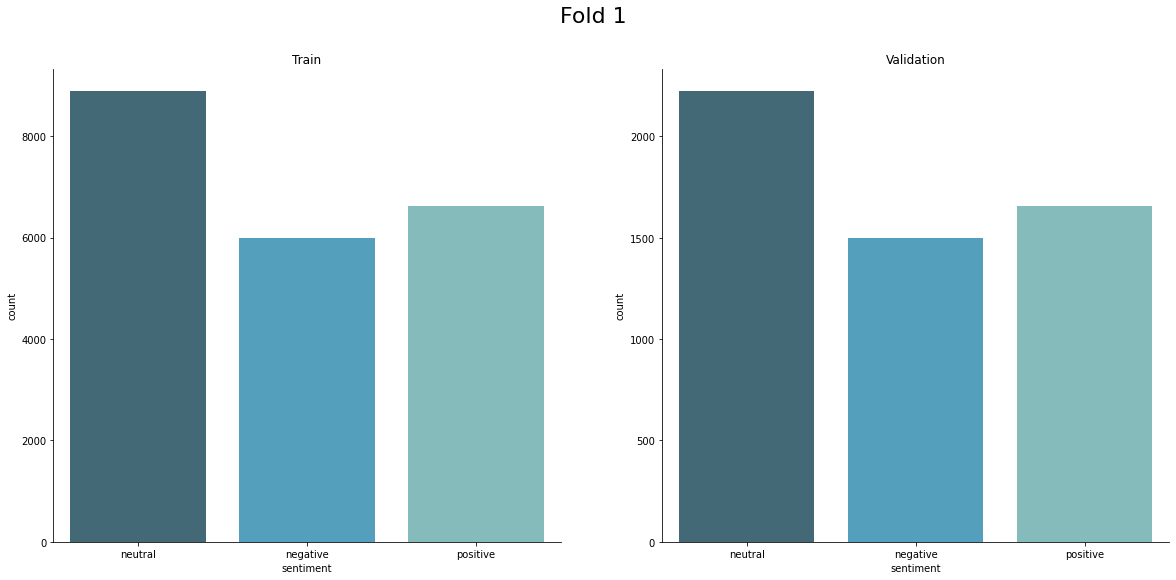

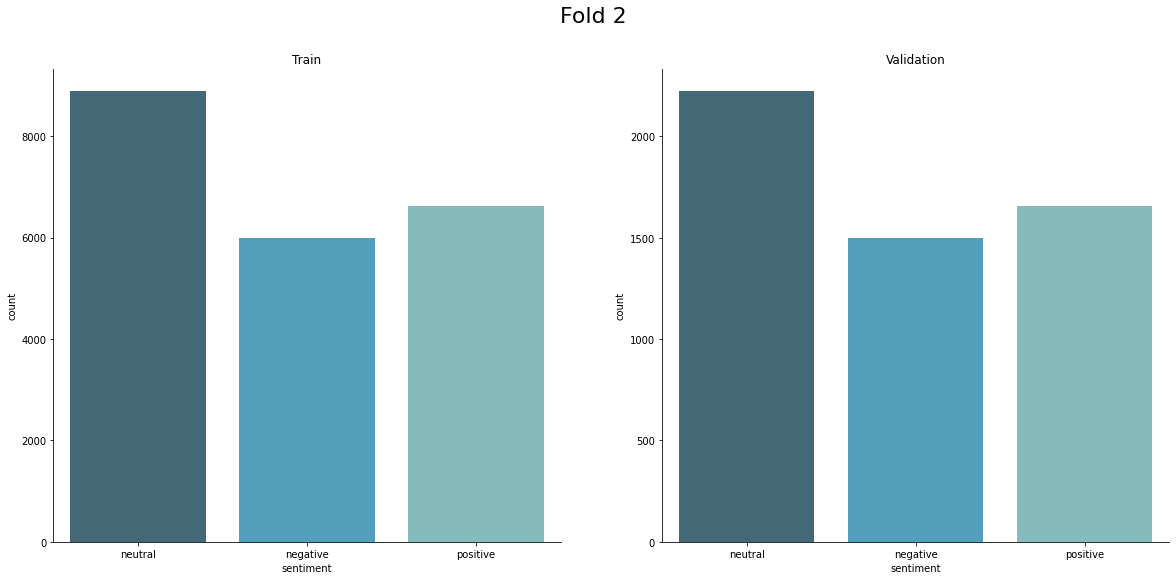

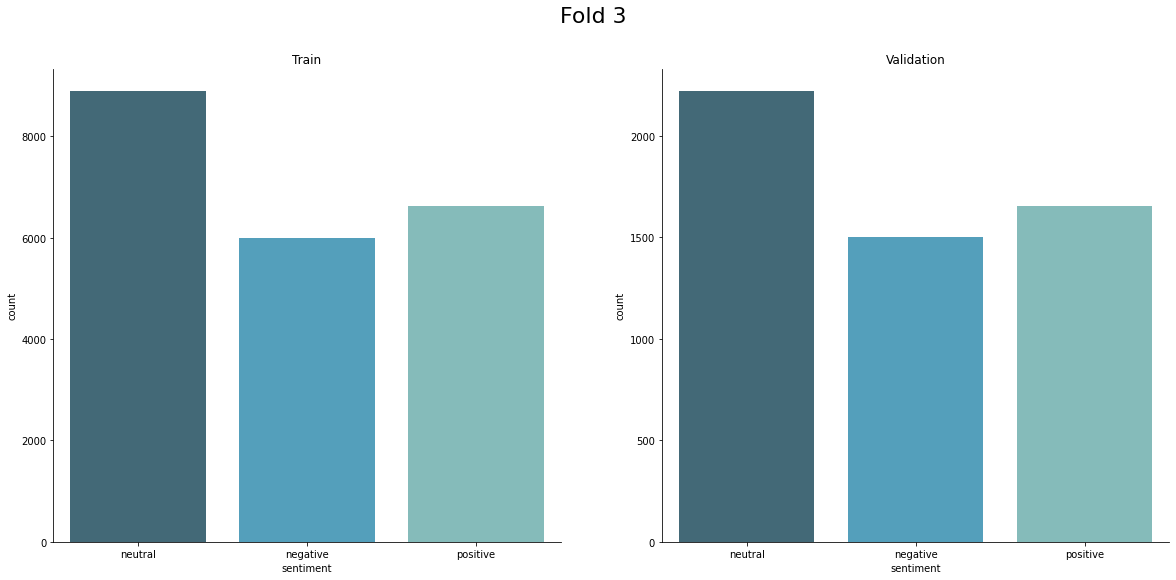

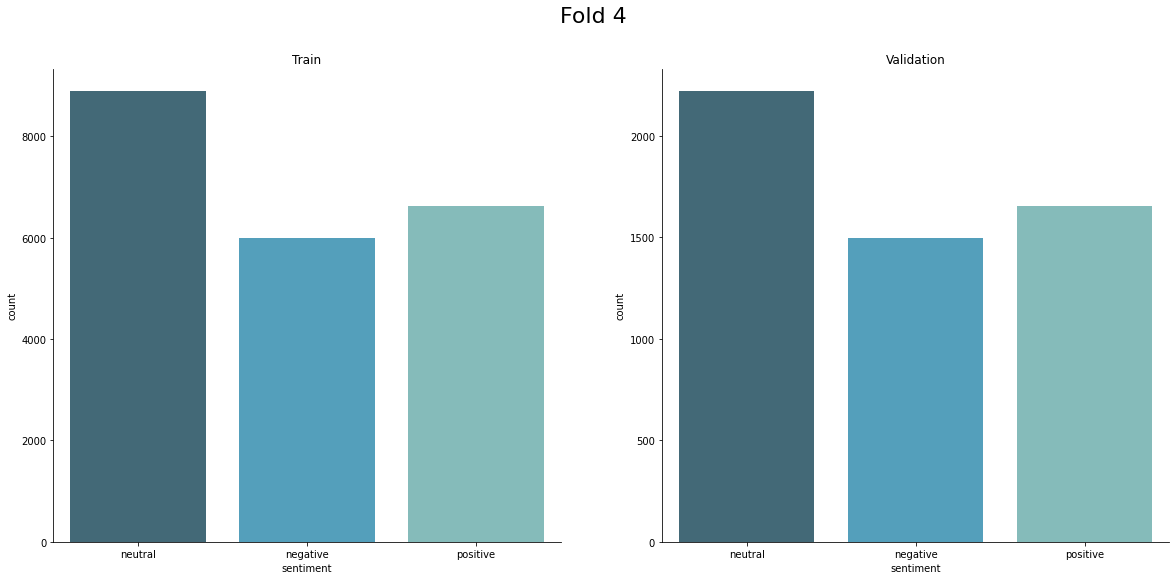

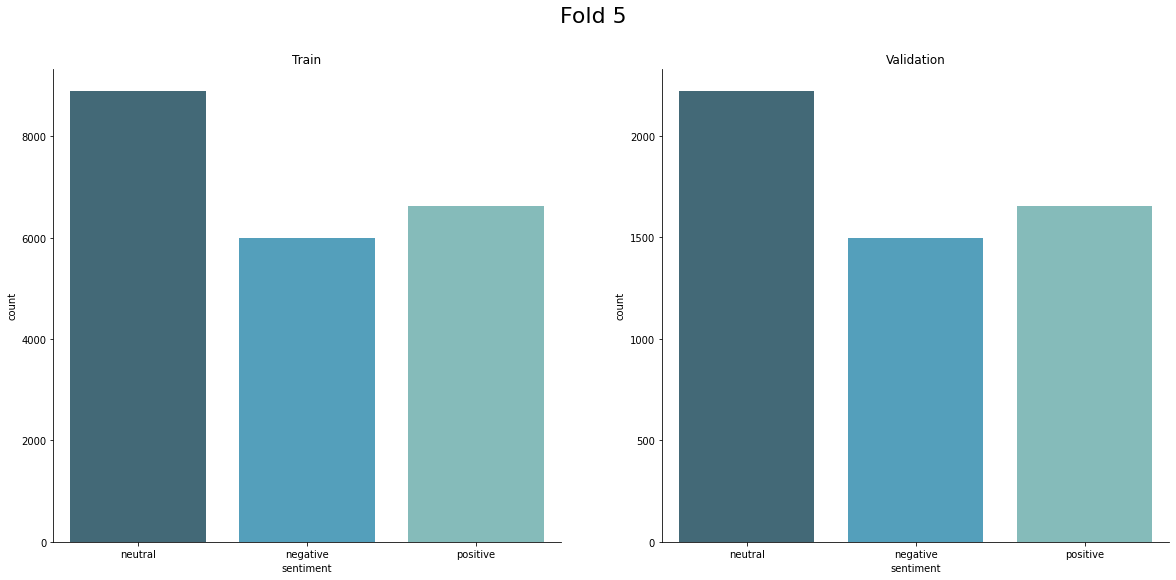

In [10]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.7))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", order=sentiment_cols, ax=ax1).set_title('Train')
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", order=sentiment_cols, ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

## Token count distribution

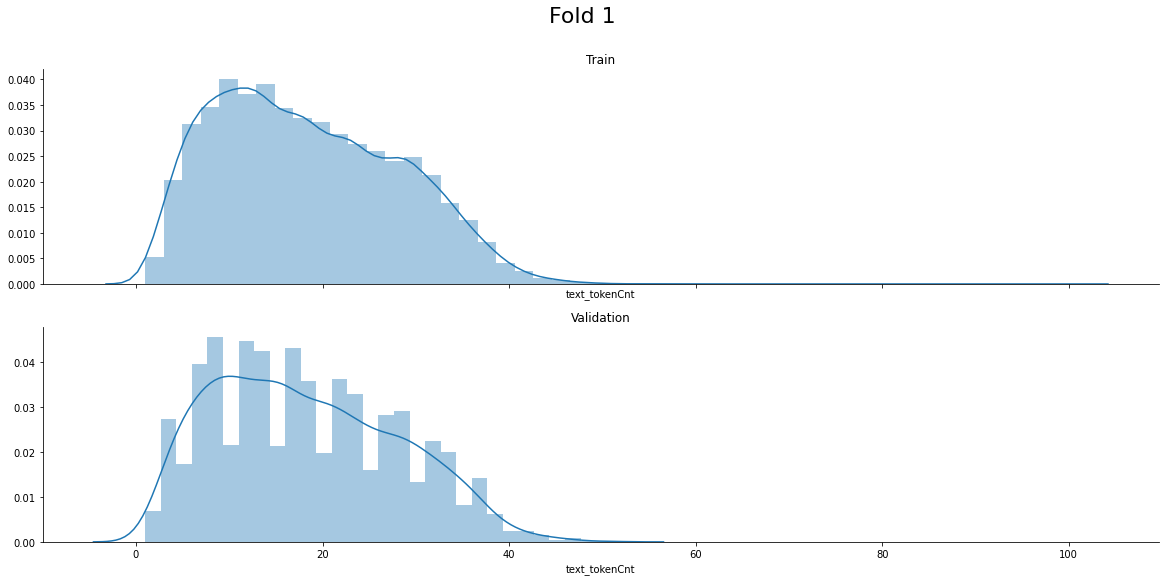

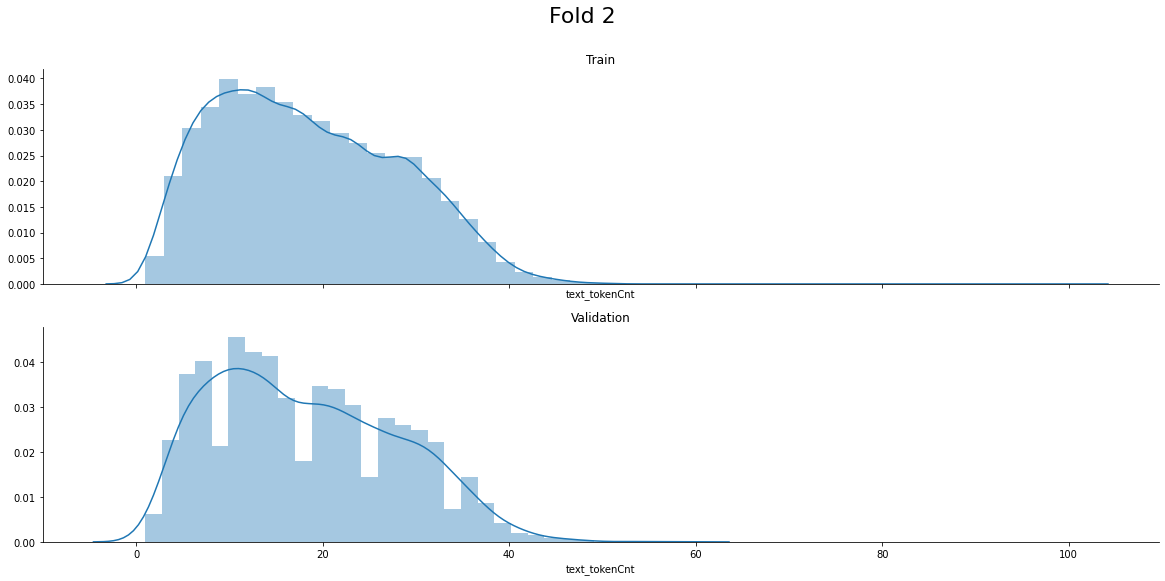

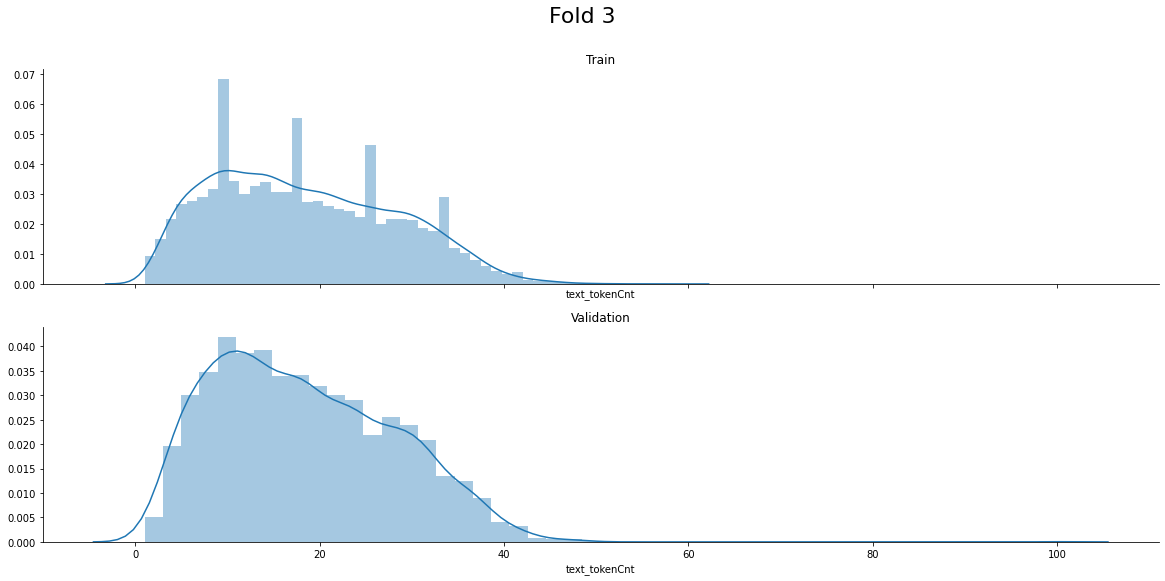

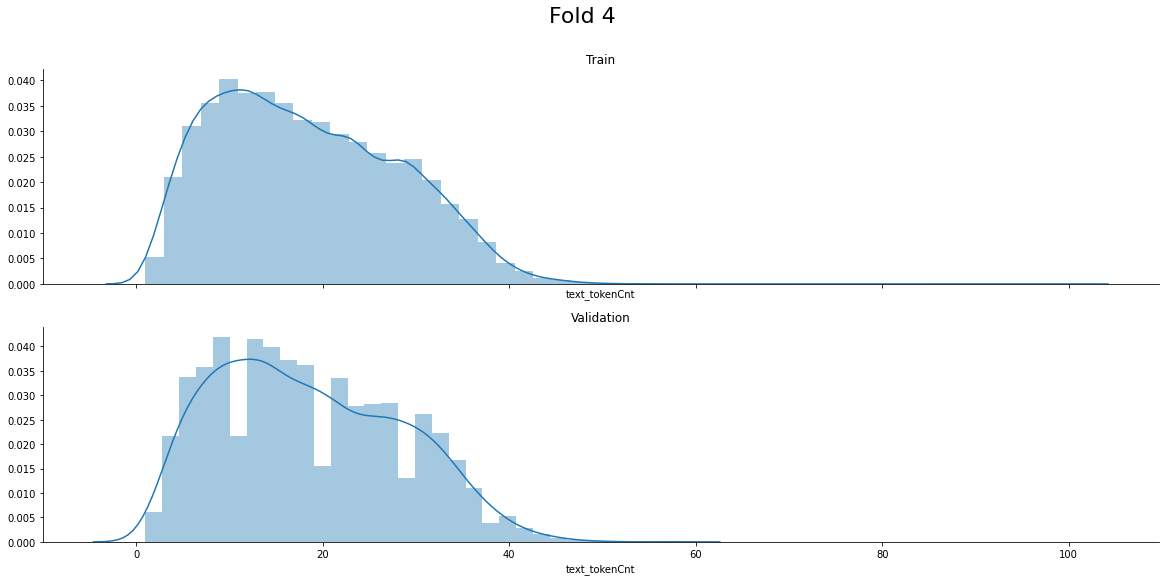

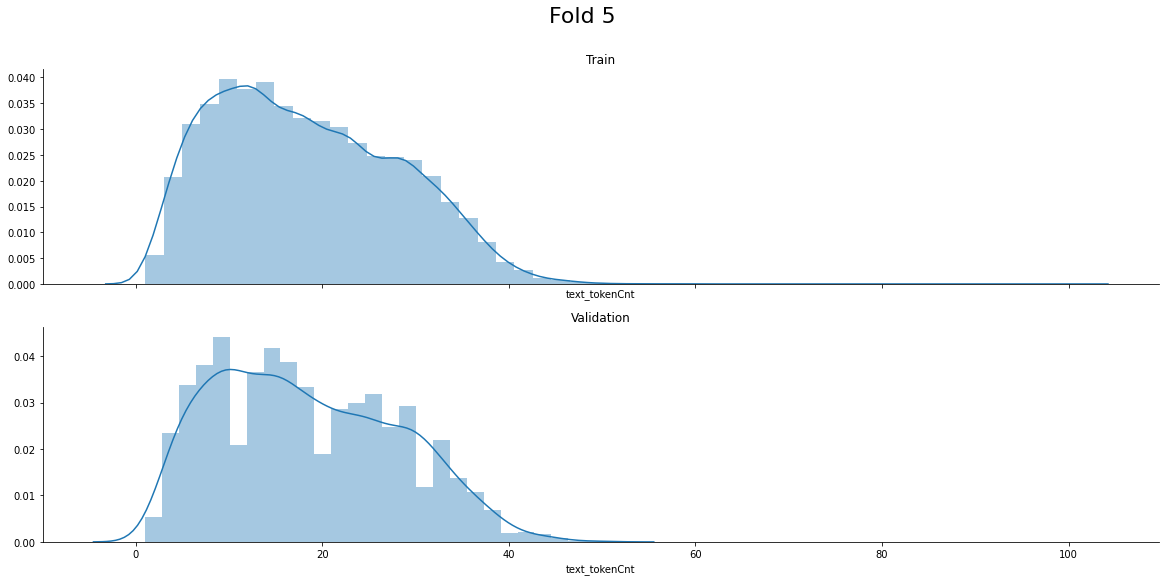

In [11]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
    fig.suptitle('Fold %s' % fold_n, fontsize=22)
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['text_tokenCnt'], ax=ax1).set_title("Train")
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['text_tokenCnt'], ax=ax2).set_title("Validation")
    sns.despine()
    plt.show()

# Output 5-fold set

In [12]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], tokenizer, 
                                                                                       MAX_LEN, preprocess_fn=preprocess_roberta)
    x_valid, x_valid_aux, x_valid_aux_2, y_valid, y_valid_mask, y_valid_aux = get_data(train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & 
                                                                                                (train_df['imputed'] == False)], tokenizer, 
                                                                                       MAX_LEN, preprocess_fn=preprocess_roberta)
    
    x_train, x_train_aux, x_train_aux_2 = np.array(x_train), np.array(x_train_aux), np.array(x_train_aux_2)
    y_train, y_train_mask, y_train_aux = np.array(y_train), np.array(y_train_mask), np.array(y_train_aux)
    x_valid, x_valid_aux, x_valid_aux_2 = np.array(x_valid), np.array(x_valid_aux), np.array(x_valid_aux_2)
    y_valid, y_valid_mask, y_valid_aux = np.array(y_valid), np.array(y_valid_mask), np.array(y_valid_aux)
    
    print('\nFOLD: %d' % (fold_n))
    print('x_train, y_train', x_train.shape, y_train.shape)
    print('x_valid, y_valid', x_valid.shape, y_valid.shape)
    print('x_train_aux, y_train_aux, x_train_aux_2', x_train_aux.shape, y_train_aux.shape, x_train_aux_2.shape)
    print('x_valid_aux, y_valid_aux, x_valid_aux_2', x_valid_aux.shape, y_valid_aux.shape, x_valid_aux_2.shape)
    print('y_train_mask', y_train_mask.shape)
    print('y_valid_mask', y_valid_mask.shape)
    
    np.save(base_path + 'x_train', x_train)
    np.save(base_path + 'y_train', y_train)
    np.save(base_path + 'x_valid', x_valid)
    np.save(base_path + 'y_valid', y_valid)
    np.save(base_path + 'x_train_aux', x_train_aux)
    np.save(base_path + 'x_train_aux_2', x_train_aux_2)
    np.save(base_path + 'y_train_mask', y_train_mask)
    np.save(base_path + 'y_train_aux', y_train_aux)
    np.save(base_path + 'x_valid_aux', x_valid_aux)
    np.save(base_path + 'x_valid_aux_2', x_valid_aux_2)
    np.save(base_path + 'y_valid_mask', y_valid_mask)
    np.save(base_path + 'y_valid_aux', y_valid_aux)
    
#  Compress logs dir
!tar -czf fold_1.tar.gz fold_1
!tar -czf fold_2.tar.gz fold_2
!tar -czf fold_3.tar.gz fold_3
!tar -czf fold_4.tar.gz fold_4
!tar -czf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
shutil.rmtree('fold_2')
shutil.rmtree('fold_3')
shutil.rmtree('fold_4')
shutil.rmtree('fold_5')

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying,negative,0.200000,25,5,6,8,1,1,train,train,train,validation,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,validation,train,False



FOLD: 1
x_train, y_train (2, 21505, 64) (2, 21505, 64)
x_valid, y_valid (2, 5377, 64) (2, 5377, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 21505) (3, 21505) (21505, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5377) (3, 5377) (5377, 3)
y_train_mask (21505, 64)
y_valid_mask (5377, 64)

FOLD: 2
x_train, y_train (2, 21505, 64) (2, 21505, 64)
x_valid, y_valid (2, 5377, 64) (2, 5377, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 21505) (3, 21505) (21505, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5377) (3, 5377) (5377, 3)
y_train_mask (21505, 64)
y_valid_mask (5377, 64)

FOLD: 3
x_train, y_train (2, 21506, 64) (2, 21506, 64)
x_valid, y_valid (2, 5376, 64) (2, 5376, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 21506) (3, 21506) (21506, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 5376) (3, 5376) (5376, 3)
y_train_mask (21506, 64)
y_valid_mask (5376, 64)

FOLD: 4
x_train, y_train (2, 21506, 64) (2, 21506, 64)
x_valid, y_valid (2, 5376, 64) (2, 5376, 64)
x_train_aux, y_train

# Output 5-fold set (positive and negative)

In [13]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'polar_fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    
    train_fold = train_df[train_df[('fold_%s' % fold_n)] == 'train'].copy()
    valid_fold = train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & (train_df['imputed'] == False)].copy()
    
    train_fold = pd.concat([train_fold[train_fold['sentiment'] == 'negative'],
                            train_fold[train_fold['sentiment'] == 'positive']])
    valid_fold = pd.concat([valid_fold[valid_fold['sentiment'] == 'negative'],
                            valid_fold[valid_fold['sentiment'] == 'positive']])
    
    train_fold = shuffle(train_fold, random_state=SEED).reset_index(drop=True)
    valid_fold = shuffle(valid_fold, random_state=SEED).reset_index(drop=True)
    
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_fold, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
    x_valid, x_valid_aux, x_valid_aux_2, y_valid, y_valid_mask, y_valid_aux = get_data(valid_fold, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
    
    x_train, x_train_aux, x_train_aux_2 = np.array(x_train), np.array(x_train_aux), np.array(x_train_aux_2)
    y_train, y_train_mask, y_train_aux = np.array(y_train), np.array(y_train_mask), np.array(y_train_aux)
    x_valid, x_valid_aux, x_valid_aux_2 = np.array(x_valid), np.array(x_valid_aux), np.array(x_valid_aux_2)
    y_valid, y_valid_mask, y_valid_aux = np.array(y_valid), np.array(y_valid_mask), np.array(y_valid_aux)
    
    
    print('\nFOLD: %d' % (fold_n))
    print('x_train, y_train', x_train.shape, y_train.shape)
    print('x_valid, y_valid', x_valid.shape, y_valid.shape)
    print('x_train_aux, y_train_aux, x_train_aux_2', x_train_aux.shape, y_train_aux.shape, x_train_aux_2.shape)
    print('x_valid_aux, y_valid_aux, x_valid_aux_2', x_valid_aux.shape, y_valid_aux.shape, x_valid_aux_2.shape)
    print('y_train_mask', y_train_mask.shape)
    print('y_valid_mask', y_valid_mask.shape)
    
    np.save(base_path + 'x_train', x_train)
    np.save(base_path + 'y_train', y_train)
    np.save(base_path + 'x_valid', x_valid)
    np.save(base_path + 'y_valid', y_valid)
    np.save(base_path + 'x_train_aux', x_train_aux)
    np.save(base_path + 'x_train_aux_2', x_train_aux_2)
    np.save(base_path + 'y_train_mask', y_train_mask)
    np.save(base_path + 'y_train_aux', y_train_aux)
    np.save(base_path + 'x_valid_aux', x_valid_aux)
    np.save(base_path + 'x_valid_aux_2', x_valid_aux_2)
    np.save(base_path + 'y_valid_mask', y_valid_mask)
    np.save(base_path + 'y_valid_aux', y_valid_aux)
    
#  Compress logs dir
!tar -czf polar_fold_1.tar.gz polar_fold_1
!tar -czf polar_fold_2.tar.gz polar_fold_2
!tar -czf polar_fold_3.tar.gz polar_fold_3
!tar -czf polar_fold_4.tar.gz polar_fold_4
!tar -czf polar_fold_5.tar.gz polar_fold_5

# Delete logs dir
shutil.rmtree('polar_fold_1')
shutil.rmtree('polar_fold_2')
shutil.rmtree('polar_fold_3')
shutil.rmtree('polar_fold_4')
shutil.rmtree('polar_fold_5')


FOLD: 1
x_train, y_train (2, 12624, 64) (2, 12624, 64)
x_valid, y_valid (2, 3156, 64) (2, 3156, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 12624) (3, 12624) (12624, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 3156) (3, 3156) (3156, 3)
y_train_mask (12624, 64)
y_valid_mask (3156, 64)

FOLD: 2
x_train, y_train (2, 12624, 64) (2, 12624, 64)
x_valid, y_valid (2, 3156, 64) (2, 3156, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 12624) (3, 12624) (12624, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 3156) (3, 3156) (3156, 3)
y_train_mask (12624, 64)
y_valid_mask (3156, 64)

FOLD: 3
x_train, y_train (2, 12624, 64) (2, 12624, 64)
x_valid, y_valid (2, 3156, 64) (2, 3156, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 12624) (3, 12624) (12624, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 3156) (3, 3156) (3156, 3)
y_train_mask (12624, 64)
y_valid_mask (3156, 64)

FOLD: 4
x_train, y_train (2, 12624, 64) (2, 12624, 64)
x_valid, y_valid (2, 3156, 64) (2, 3156, 64)
x_train_aux, y_train

# Output 5-fold set (balanced)

In [14]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'balanced_fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    
    train_fold = train_df[train_df[('fold_%s' % fold_n)] == 'train'].copy()
    valid_fold = train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & (train_df['imputed'] == False)].copy()
    
    # Sample data by lower bound
    lower_count_train = min(len(train_fold[train_fold['sentiment'] == 'neutral']), 
                            len(train_fold[train_fold['sentiment'] == 'negative']), 
                            len(train_fold[train_fold['sentiment'] == 'positive']))
    lower_count_valid = min(len(valid_fold[valid_fold['sentiment'] == 'neutral']), 
                            len(valid_fold[valid_fold['sentiment'] == 'negative']), 
                            len(valid_fold[valid_fold['sentiment'] == 'positive']))

    train_fold = pd.concat([train_fold[train_fold['sentiment'] == 'neutral'].sample(n=lower_count_train, random_state=SEED),
                            train_fold[train_fold['sentiment'] == 'negative'].sample(n=lower_count_train, random_state=SEED),
                            train_fold[train_fold['sentiment'] == 'positive'].sample(n=lower_count_train, random_state=SEED),
                           ])
    valid_fold = pd.concat([valid_fold[valid_fold['sentiment'] == 'neutral'].sample(n=lower_count_valid, random_state=SEED),
                            valid_fold[valid_fold['sentiment'] == 'negative'].sample(n=lower_count_valid, random_state=SEED),
                            valid_fold[valid_fold['sentiment'] == 'positive'].sample(n=lower_count_valid, random_state=SEED),
                           ])
    
    train_fold = shuffle(train_fold, random_state=SEED).reset_index(drop=True)
    valid_fold = shuffle(valid_fold, random_state=SEED).reset_index(drop=True)
    
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_fold, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
    x_valid, x_valid_aux, x_valid_aux_2, y_valid, y_valid_mask, y_valid_aux = get_data(valid_fold, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
    
    x_train, x_train_aux, x_train_aux_2 = np.array(x_train), np.array(x_train_aux), np.array(x_train_aux_2)
    y_train, y_train_mask, y_train_aux = np.array(y_train), np.array(y_train_mask), np.array(y_train_aux)
    x_valid, x_valid_aux, x_valid_aux_2 = np.array(x_valid), np.array(x_valid_aux), np.array(x_valid_aux_2)
    y_valid, y_valid_mask, y_valid_aux = np.array(y_valid), np.array(y_valid_mask), np.array(y_valid_aux)
    
    
    print('\nFOLD: %d' % (fold_n))
    print('x_train, y_train', x_train.shape, y_train.shape)
    print('x_valid, y_valid', x_valid.shape, y_valid.shape)
    print('x_train_aux, y_train_aux, x_train_aux_2', x_train_aux.shape, y_train_aux.shape, x_train_aux_2.shape)
    print('x_valid_aux, y_valid_aux, x_valid_aux_2', x_valid_aux.shape, y_valid_aux.shape, x_valid_aux_2.shape)
    print('y_train_mask', y_train_mask.shape)
    print('y_valid_mask', y_valid_mask.shape)
    
    np.save(base_path + 'x_train', x_train)
    np.save(base_path + 'y_train', y_train)
    np.save(base_path + 'x_valid', x_valid)
    np.save(base_path + 'y_valid', y_valid)
    np.save(base_path + 'x_train_aux', x_train_aux)
    np.save(base_path + 'x_train_aux_2', x_train_aux_2)
    np.save(base_path + 'y_train_mask', y_train_mask)
    np.save(base_path + 'y_train_aux', y_train_aux)
    np.save(base_path + 'x_valid_aux', x_valid_aux)
    np.save(base_path + 'x_valid_aux_2', x_valid_aux_2)
    np.save(base_path + 'y_valid_mask', y_valid_mask)
    np.save(base_path + 'y_valid_aux', y_valid_aux)
    
#  Compress logs dir
!tar -czf balanced_fold_1.tar.gz balanced_fold_1
!tar -czf balanced_fold_2.tar.gz balanced_fold_2
!tar -czf balanced_fold_3.tar.gz balanced_fold_3
!tar -czf balanced_fold_4.tar.gz balanced_fold_4
!tar -czf balanced_fold_5.tar.gz balanced_fold_5

# Delete logs dir
shutil.rmtree('balanced_fold_1')
shutil.rmtree('balanced_fold_2')
shutil.rmtree('balanced_fold_3')
shutil.rmtree('balanced_fold_4')
shutil.rmtree('balanced_fold_5')


FOLD: 1
x_train, y_train (2, 17991, 64) (2, 17991, 64)
x_valid, y_valid (2, 4497, 64) (2, 4497, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 17991) (3, 17991) (17991, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 4497) (3, 4497) (4497, 3)
y_train_mask (17991, 64)
y_valid_mask (4497, 64)

FOLD: 2
x_train, y_train (2, 17991, 64) (2, 17991, 64)
x_valid, y_valid (2, 4497, 64) (2, 4497, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 17991) (3, 17991) (17991, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 4497) (3, 4497) (4497, 3)
y_train_mask (17991, 64)
y_valid_mask (4497, 64)

FOLD: 3
x_train, y_train (2, 17988, 64) (2, 17988, 64)
x_valid, y_valid (2, 4500, 64) (2, 4500, 64)
x_train_aux, y_train_aux, x_train_aux_2 (1, 17988) (3, 17988) (17988, 3)
x_valid_aux, y_valid_aux, x_valid_aux_2 (1, 4500) (3, 4500) (4500, 3)
y_train_mask (17988, 64)
y_valid_mask (4500, 64)

FOLD: 4
x_train, y_train (2, 17991, 64) (2, 17991, 64)
x_valid, y_valid (2, 4497, 64) (2, 4497, 64)
x_train_aux, y_train

## Tokenizer sanity check (no QA)

In [15]:
# for idx in range(5):
#     print('\nRow %d' % idx)
#     max_seq_len = 32
#     text = train_df['text'].values[idx]
#     selected_text = train_df['selected_text'].values[idx]
    
#     _,  (target_start, target_end, _) = preprocess_text.preprocess_roberta(' ' + text, selected_text, tokenizer, max_seq_len)
    
#     decoded_text = preprocess_text.decode(target_start.argmax(), target_end.argmax(), text, tokenizer)
    
#     print('text         : "%s"' % text)
#     print('selected_text: "%s"' % selected_text)
#     print('decoded_text : "%s"' % decoded_text)
    
#     assert selected_text == decoded_text

## Data generation sanity check (no QA)

In [16]:
# for idx in range(5):
#     print('\nRow %d' % idx)
#     max_seq_len = 24
#     text = train_df['text'].values[idx]
#     selected_text = train_df['selected_text'].values[idx]
#     jaccard = train_df['jaccard'].values[idx]
#     selected_text_wordCnt = train_df['selected_text_wordCnt'].values[idx]
    
#     x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = preprocess_text.get_data(train_df[idx:idx+1], tokenizer, max_seq_len, 
#                                                                                                        preprocess_fn=preprocess_text.preprocess_roberta)
    
#     print('text          : "%s"'   % text)
#     print('jaccard       : "%.4f"' % jaccard)
#     print('sentiment     : "%s"'   % question)
#     print('word count    : "%d"'   % selected_text_wordCnt)
    
#     print('input_ids     : "%s"'   % x_train[0][0])
#     print('attention_mask: "%s"'   % x_train[1][0])
#     print('sentiment     : "%d"'   % x_train_aux[0])
#     print('sentiment OHE : "%s"'   % x_train_aux_2[0])
    
#     print('selected_text : "%s"'   % selected_text)
#     print('start         : "%s"'   % y_train[0][0])
#     print('end           : "%s"'   % y_train[1][0])
#     print('mask          : "%s"'   % y_train_mask[0])
#     print('jaccard       : "%.4f"' % y_train_aux[0][0])
#     print('word count    : "%d"'   % y_train_aux[1][0])
    
#     assert len(x_train) == 2
#     assert len(x_train_aux) == 1
#     assert len(x_train_aux_2) == 1
#     assert len(y_train) == 2
#     assert len(y_train_mask) == 1
#     assert len(y_train_aux) == 3
    
#     assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len
#     assert len(y_train[0][0]) == len(y_train[1][0]) == len(y_train_mask[0]) == max_seq_len

# Output 5-fold set (no QA)

In [17]:
# for fold_n in range(folds.n_splits):
#     fold_n += 1
    
#     base_path = 'no_qa_fold_%d/' % fold_n
#     # Create dir
#     os.makedirs(base_path)
    
#     x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = preprocess_text.get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], tokenizer, 
#                                                                                                        MAX_LEN, preprocess_fn=preprocess_text.preprocess_roberta)
#     x_valid, x_valid_aux, x_valid_aux_2, y_valid, y_valid_mask, y_valid_aux = preprocess_text.get_data(train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & 
#                                                                                                                 (train_df['imputed'] == False)], tokenizer, 
#                                                                                                        MAX_LEN, preprocess_fn=preprocess_text.preprocess_roberta)
    
#     x_train, x_train_aux, x_train_aux_2 = np.array(x_train), np.array(x_train_aux), np.array(x_train_aux_2)
#     y_train, y_train_mask, y_train_aux = np.array(y_train), np.array(y_train_mask), np.array(y_train_aux)
#     x_valid, x_valid_aux, x_valid_aux_2 = np.array(x_valid), np.array(x_valid_aux), np.array(x_valid_aux_2)
#     y_valid, y_valid_mask, y_valid_aux = np.array(y_valid), np.array(y_valid_mask), np.array(y_valid_aux)
    
#     print('\nFOLD: %d' % (fold_n))
#     print('x_train, y_train', x_train.shape, y_train.shape)
#     print('x_valid, y_valid', x_valid.shape, y_valid.shape)
#     print('x_train_aux, y_train_aux, x_train_aux_2', x_train_aux.shape, y_train_aux.shape, x_train_aux_2.shape)
#     print('x_valid_aux, y_valid_aux, x_valid_aux_2', x_valid_aux.shape, y_valid_aux.shape, x_valid_aux_2.shape)
#     print('y_train_mask', y_train_mask.shape)
#     print('y_valid_mask', y_valid_mask.shape)
    
#     np.save(base_path + 'x_train', x_train)
#     np.save(base_path + 'y_train', y_train)
#     np.save(base_path + 'x_valid', x_valid)
#     np.save(base_path + 'y_valid', y_valid)
#     np.save(base_path + 'x_train_aux', x_train_aux)
#     np.save(base_path + 'x_train_aux_2', x_train_aux_2)
#     np.save(base_path + 'y_train_mask', y_train_mask)
#     np.save(base_path + 'y_train_aux', y_train_aux)
#     np.save(base_path + 'x_valid_aux', x_valid_aux)
#     np.save(base_path + 'x_valid_aux_2', x_valid_aux_2)
#     np.save(base_path + 'y_valid_mask', y_valid_mask)
#     np.save(base_path + 'y_valid_aux', y_valid_aux)
    
# #  Compress logs dir
# !tar -czf no_qa_fold_1.tar.gz no_qa_fold_1
# !tar -czf no_qa_fold_2.tar.gz no_qa_fold_2
# !tar -czf no_qa_fold_3.tar.gz no_qa_fold_3
# !tar -czf no_qa_fold_4.tar.gz no_qa_fold_4
# !tar -czf no_qa_fold_5.tar.gz no_qa_fold_5

# # Delete logs dir
# shutil.rmtree('no_qa_fold_1')
# shutil.rmtree('no_qa_fold_2')
# shutil.rmtree('no_qa_fold_3')
# shutil.rmtree('no_qa_fold_4')
# shutil.rmtree('no_qa_fold_5')

# Test set EDA

In [18]:
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

# pre-process
test_df["text"] = test_df["text"].apply(lambda x: x.strip())
test_df["text"] = test_df["text"].apply(lambda x: x.lower())

test_df["text"] = test_df["text"].apply(lambda x: split_punctuation(x))

test_df['text_len'] = test_df['text'].apply(lambda x : len(x))
test_df['text_wordCnt'] = test_df['text'].apply(lambda x : len(x.split(' ')))
test_df['text_tokenCnt'] = test_df['text'].apply(lambda x : len(tokenizer.encode(x).ids))

print('Test samples: %s' % len(test_df))
display(test_df.head())
display(test_df.describe())

Test samples: 3534


,textID,text,sentiment,text_len,text_wordCnt,text_tokenCnt
0,f87dea47db,last session of the day http : / / twitpic . com / 67ezh,neutral,56,14,18
1,96d74cb729,shanghai is also really exciting ( precisely - - skyscrapers galore ) . good tweeps in china : ( sh ) ( bj ) .,positive,110,25,33
2,eee518ae67,"recession hit veronique branquinho , she has to quit her company , such a shame !",negative,81,16,20
3,01082688c6,happy bday !,positive,12,3,4
4,33987a8ee5,http : / / twitpic . com / 4w75p - i like it ! !,positive,48,15,20


,text_len,text_wordCnt,text_tokenCnt
count,3534.000000,3534.000000,3534.000000
mean,70.148557,16.007640,18.620260
std,37.097980,8.616639,10.064474
min,3.000000,1.000000,1.000000
25%,39.000000,9.000000,10.000000
50%,66.000000,15.000000,17.000000
75%,100.000000,22.000000,26.000000
max,189.000000,61.000000,70.000000


## Sentiment distribution

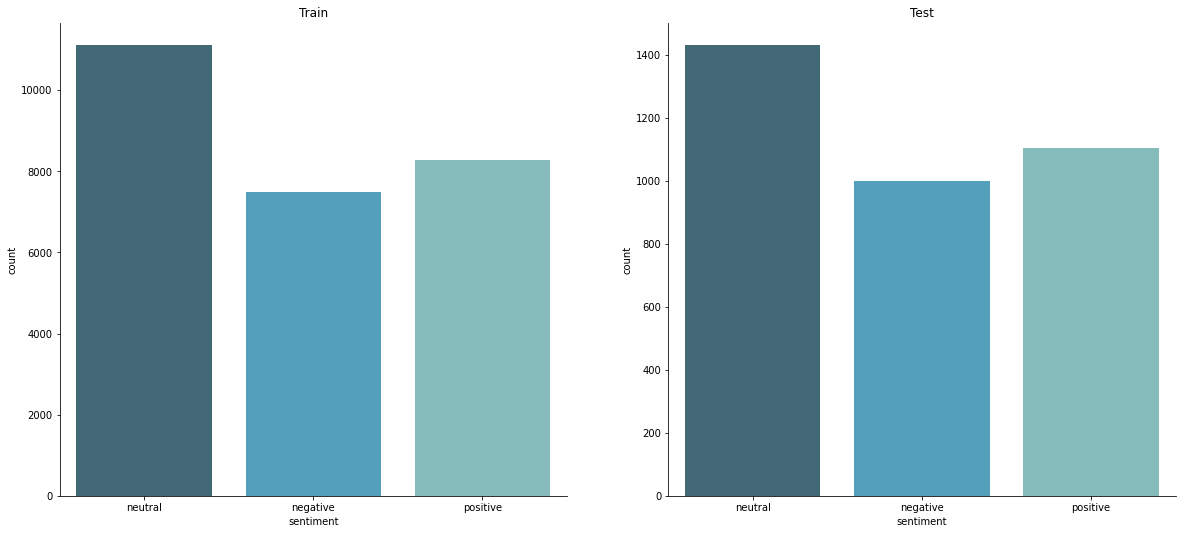

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.7))
sns.countplot(x="sentiment", data=train_df, palette="GnBu_d", order=sentiment_cols, ax=ax1).set_title('Train')
sns.countplot(x="sentiment", data=test_df, palette="GnBu_d", order=sentiment_cols, ax=ax2).set_title('Test')
sns.despine()
plt.show()

## Word count distribution

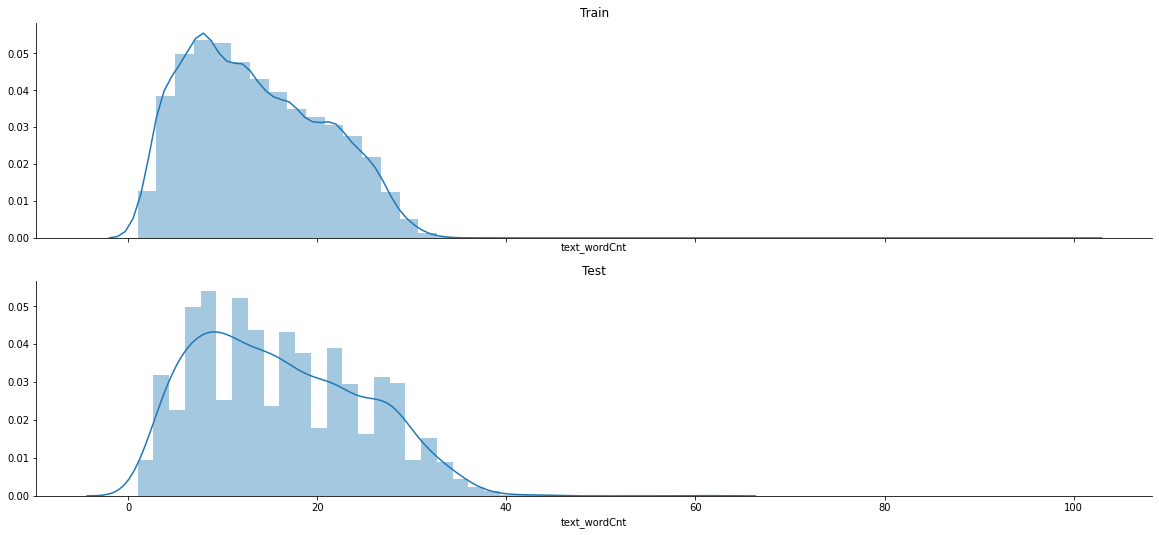

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['text_wordCnt'], ax=ax1).set_title("Train")
sns.distplot(test_df['text_wordCnt'], ax=ax2).set_title("Test")
sns.despine()
plt.show()

## Token count distribution

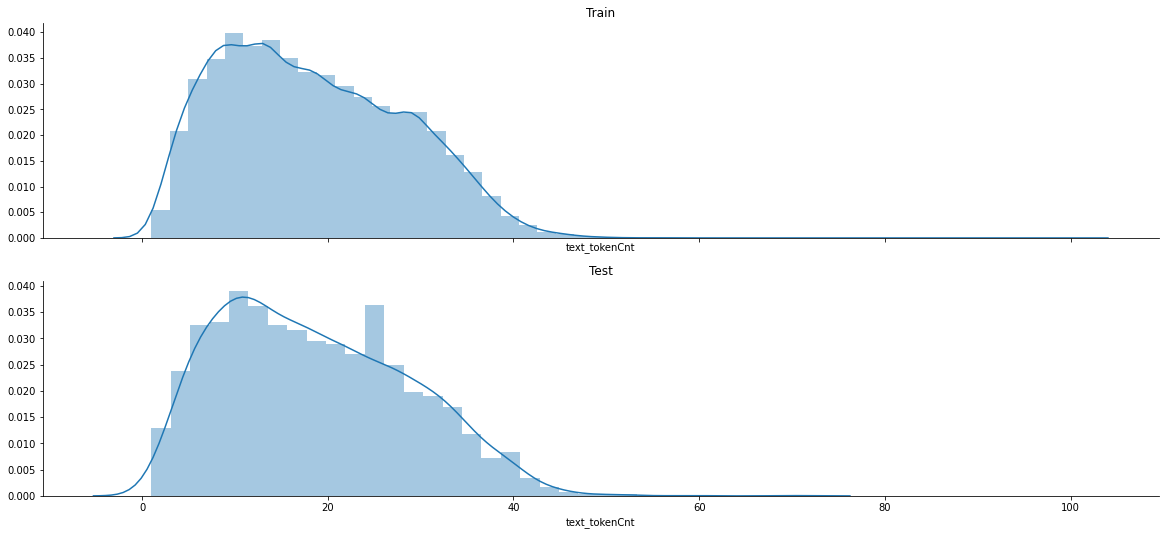

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['text_tokenCnt'], ax=ax1).set_title("Train")
sns.distplot(test_df['text_tokenCnt'], ax=ax2).set_title("Test")
sns.despine()
plt.show()

## Token count distribution (selected_text)

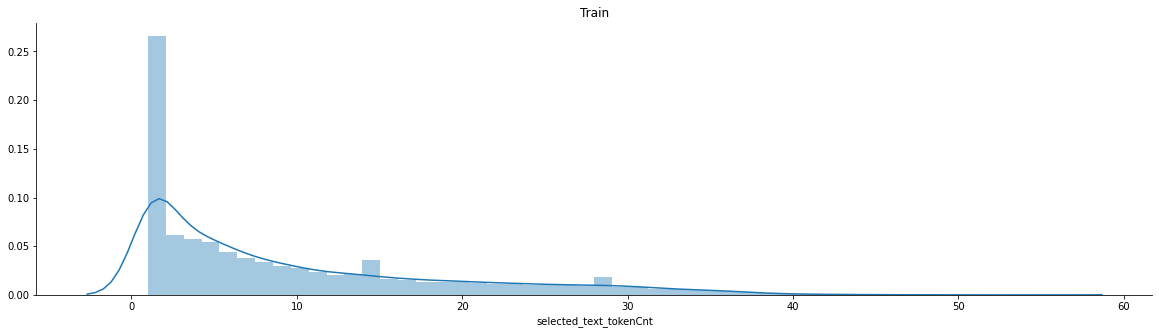

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True)
sns.distplot(train_df['selected_text_tokenCnt'], ax=ax).set_title("Train")
sns.despine()
plt.show()

# Original set

In [23]:
original_df = pd.read_csv("https://raw.githubusercontent.com/Galanopoulog/DATA607-Project-4/master/TextEmotion.csv")

# pre-process
original_df.dropna(inplace=True)
original_df = original_df.reset_index()
original_df.drop('index', axis=1, inplace=True)
original_df['content'] = original_df['content'].apply(lambda x: x.strip())
original_df['content'] = original_df['content'].apply(lambda x: x.lower())

original_df["content"] = original_df["content"].apply(lambda x: split_punctuation(x))

original_df['text_len'] = original_df['content'].apply(lambda x : len(x))
original_df['text_wordCnt'] = original_df['content'].apply(lambda x : len(x.split(' ')))
original_df['text_tokenCnt'] = original_df['content'].apply(lambda x : len(tokenizer.encode(x).ids))

display(original_df.head())
display(original_df.describe())

,tweet_id,sentiment,author,content,text_len,text_wordCnt,text_tokenCnt
0,1956967341,empty,xoshayzers,@ tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part = [,93,20,25
1,1956967666,sadness,wannamama,layin n bed with a headache ughhhh . . . waitin on your call . . .,66,17,21
2,1956967696,sadness,coolfunky,funeral ceremony . . . gloomy friday . . .,42,10,11
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends soon !,37,8,8
4,1956968416,neutral,xkilljoyx,"@ dannycastillo we want to trade with someone who has houston tickets , but no one will .",89,18,22


,tweet_id,text_len,text_wordCnt,text_tokenCnt
count,4.000000e+04,40000.000000,40000.000000,40000.000000
mean,1.845184e+09,77.646375,17.889900,21.054875
std,1.188579e+08,38.732189,9.412149,10.693034
min,1.693956e+09,1.000000,1.000000,1.000000
25%,1.751431e+09,46.000000,10.000000,12.000000
50%,1.855443e+09,73.000000,17.000000,20.000000
75%,1.962781e+09,109.000000,25.000000,29.000000
max,1.966441e+09,223.000000,106.000000,114.000000


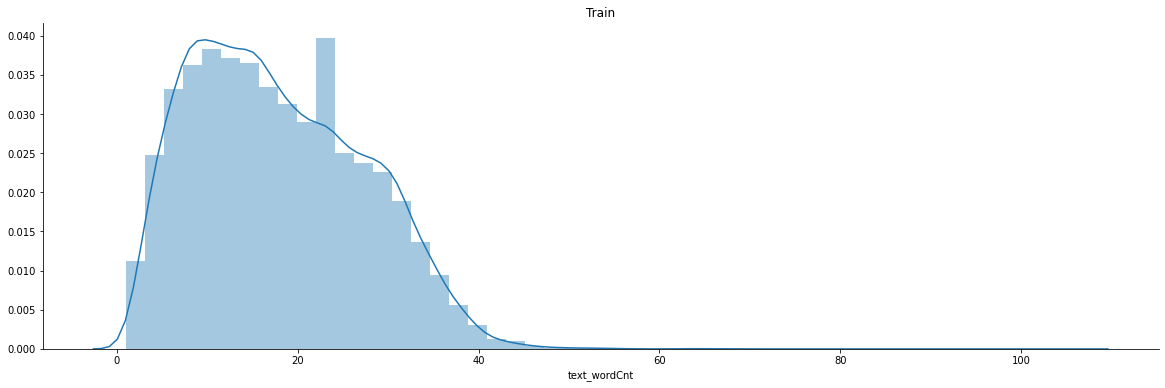

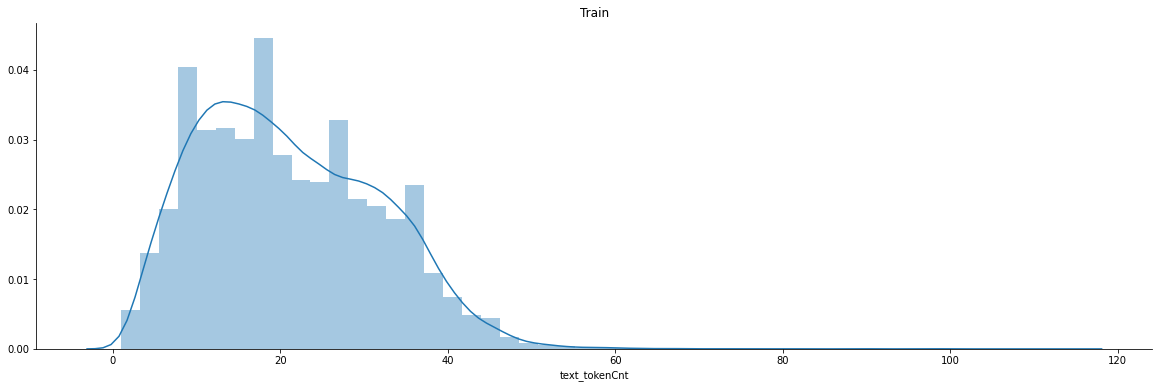

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)
sns.distplot(original_df['text_wordCnt'], ax=ax).set_title("Train")
sns.despine()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)
sns.distplot(original_df['text_tokenCnt'], ax=ax).set_title("Train")
sns.despine()
plt.show()